## Spectral Energy Density Fitting and Dark Matter Limit Extraction


#### Motivation

Now we are going to discuss how we can use build a summary data product that can be used to quickly fit a wide variety of different DM spectra.

Recall that the previous example involved fitting the data across all energy bins using a powerlaw with index -2 for the dark matter target.

What we would like to do is extract the spectrum of any excess (i.e., the flux or limits associated with the various energy bins) and then fit the various DM model spectra to the observed spectra.

Something like this:

<img src="figures/ADW_spectrum.png" width=400px>

So then we would be fitting various DM models against the spectral data points, rather than the counts data, as we did in the previous example.   Typically we might use the uncertainties of the data points and do a $\chi^2$ fit for the DM spectrum.

There are two main issues with that approach.   

1.  Because many of our energy bins have very low statistics, the symmetric error bars that you would want to use, which are obtained by approximating the log-Likelihood surface as a parabola near the minimum, are not actually a good representation of the true log-Likelihood.
1.  Since we are doing a search for signal of new physics, it is likely that in many of the energy bins we will actually be reporting upper limits instead of flux points with error bars.   Because upper limits combine to pieces of information (the mean value and the uncertainty) into a single number ( the upper limit ) there isn't a good way to combine upper limits.   Consider, for example ,two measurements, the first being $1.0 \pm 0.5$ and the second being $1.9 \pm 0.05$.   If we took upper limits as the best-fit value plus 2 sigma both results would give us upper limits of 2.0.   What we have lost in reporting only the upper limit is the information about if the data are consistent with the null-hypothesis. 

So the best way to combine the information from the various energy bins is to combine the likelihoods.   

#### Overview of the Methodology

First we need to extract the log-likelihood versus flux in each energy bin seperately.   In any one energy bin, the analysis is just the same as what we did in the previous example, except that we only use the data and model in a single energy bin.

For a single energy bin the results may look something like this:

<img src="figures/ADW_1bin.png" width=400px> 

Where the delta log-likelihood is being plot on the color scale.

For two energy bins the results might look like this:

<img src="figures/ADW_2bins.png" width=400px> 

And finally, for all of the energy bins the results might look like this:

<img src="figures/ADW_allBins.png" width=400px> 

This last figure is called a "Castro" plot.  


Basically, the dark red bands show the regions favored by the data, and the other colors show the regions increasingly disfavored by the data.   

Here is another version of the same plot, where we have added the 95% CL upper limits in each of the energy bands.

<img src="figures/ADW_allBins_limits.png" width=400px> 


Recall: the confidence level here is not quantifying the probability of the energy flux taking a value below the given 95% limit - that would be a Bayesian statement. 

##### Question:

What is the corect phrasing we should use when describing the meaning of these upper limits?

If we assume a particular spectral form for the DM signal, we can use the data that went into the Castro plot to construct the log-likelihood as a function of the paramaters of the function we assumed.   In our case we will be assuming the annihilation channel and mass of the DM, so the only free parameter is the normalization of the signal.

<img src="figures/ADW_castro_spectrum.png" width=400px> 

Here are what the 95% CL upper limits would look like in this simulation for DM annihilating to b-quarks, for several different DM masses.

<img src="figures/ADW_spectra_limits.png" width=400px> 

By way of comparison, here is the upper limits on the spectrum you would get if you simply required that the curve did not exceed any of the single bin upper limits, which you can see is markedly worse.    

<img src="figures/ADW_binLimits_spectrum.png" width=400px> 

##### Question:

Why does this plot not tell us the correct upper limit on the spectrum normalization?

Finally, here is what a positive dection of a signal might look like:

<img src="figures/ADW_detection.png" width=400px> 

#### Our example

There are two file that we will use to work this example that we should take a close look at.  
The first is the `draco_sed.yaml` file in the results directory.  It constains the likelihood versus flux results from the same simulation of 6 years of data we used in the first example.


In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import LikeFitUtils as lfu
import SedUtils as SED

# lets open the file and have a look
import yaml
f_sed = yaml.load(open("results/draco_sed.yaml"))
len(f_sed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


24

Ok, the file contains 24 sets of curves, one for each energy bin.

Let's have a look at one of the sets of results.

In [58]:
f_sed[0].keys()

['flux', 'logLike', 'eflux2npred', 'emin', 'emax', 'eflux']

In [59]:
print "Energy range of bin 0 is %.1e to %.1e MeV"%(f_sed[0]['emin'],f_sed[0]['emax'])
print "Flux values scanned range from %.1e to %.1e ph cm^-2 s^-1"%(f_sed[0]['flux'][0],f_sed[0]['flux'][-1])
print "The corresponding energy flux values range from %.1e to %.1e MeV cm^-2 s^-1"%(f_sed[0]['eflux'][0],f_sed[0]['eflux'][-1])
print "The resulting delta log-Likelihood values at the edges of the scan are %.1f and %.1f"%(f_sed[0]['logLike'][0],f_sed[0]['logLike'][-1])
print "The conversion factor from energy flux to number of predicted counts is %.1e"%f_sed[0]['eflux2npred']

Energy range of bin 0 is 5.0e+02 to 6.7e+02 MeV
Flux values scanned range from 0.0e+00 to 1.7e-07 ph cm^-2 s^-1
The corresponding energy flux values range from 0.0e+00 to 9.9e-05 MeV cm^-2 s^-1
The resulting delta log-Likelihood values at the edges of the scan are -0.1 and -30126.2
The conversion factor from energy flux to number of predicted counts is 3.6e+08


So, as stated, that file contains everything we need to make the Castro plot.

I've put some utilities in `SedUtils.py`.  These are functions to do things like interpolate the log-likelihood in each energy bin and then sum them together.   I've added a small python class to manage things.

In [60]:
import SedUtils as SED

sed = SED.SED(f_sed)
help(sed)

Help on instance of SED in module SedUtils:

class SED
 |  This is a small utility class to add together the log-likelihoods for several energy bins
 |  
 |  Methods defined here:
 |  
 |  BinByBinULs(self)
 |      Calculat the 95% CL Upper limits in each energy bin and return them
 |  
 |  Minimize(self, fluxVals, x0)
 |      Minimize the negative log-likelihood w.r.t. an overall scale factor, given an input spectrum
 |      
 |      fluxVals   :   The baseline flux values, we will be fitting for a globlal scale factor w.r.t. these values           
 |      x0         :   Initial value for the global scale factor
 |      
 |      returns a scipy.optimize result object
 |  
 |  NLL_func(self, fluxVals)
 |      Returns a function of a single normalization paramter that can be passed to a minimizer
 |      
 |      fluxVals   :   The baseline flux values, we will be fitting for a globlal scale factor w.r.t. these values
 |  
 |  __call__(self, fluxVals)
 |      Return the log-likelihood 

Ok, lets go ahead and take a look at the SED that we have.

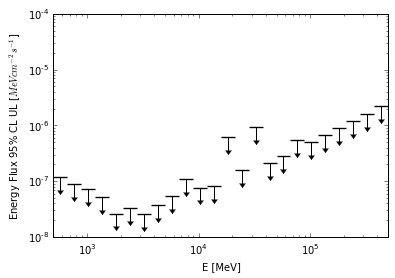

In [61]:
sed.binByBinUls = None
binByBinULs = sed.BinByBinULs()
figSED,axSED = SED.PlotSED(sed.energyBins,binByBinULs)

Ok, recall that we should never plot upper limits without also giving information about the expected upper limits.   There is a file in the "ancil" sub-directory that has the quantiles for the upper limits from 300 Monte Carlo simulations of the analysis.  

A pretty standard way to give a sense of the consistency of the results is to show the so called "Brazil" bands for the upper limits.   I.e., expectation bands made from simulating the analysis chain numerous times.  Typically people show the 1 and 2 $\sigma$ expectation bands and plot them in yellow and green, thus the name "Brazil".

In [62]:
# let's get the file with the expected upper limits
f_sed_bands = yaml.load(open("ancil/draco_sed_mc_bands.yaml"))

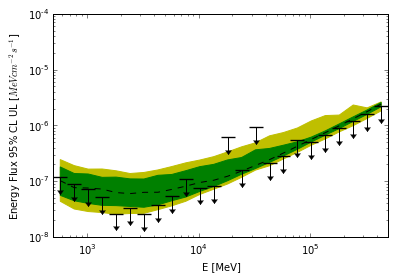

In [63]:
figSED2,axSED2 = SED.PlotSED(sed.energyBins,binByBinULs,f_sed_bands)

#### Question: does this SED plot look reasonable to you.

The second file is the `DM_spectra.yaml` file in the "ancil" directory.   This file gives the DM spectra for several different masses for the $b\hat{b}$ and $\tau^+\tau^-$ channels.   I made this file specifically to match our analysis and our energy binning.

In [64]:
f_dmspec = yaml.load(open("ancil/DM_spectra.yaml"))
print "Channels loaded are",f_dmspec.keys()
masses_bb = f_dmspec['bb'].keys()
masses_bb.sort()
masses_tau = f_dmspec['tautau'].keys()
masses_tau.sort()
fluxVals = f_dmspec['bb'][100]
print "Masses for the bb channel are",masses_bb
print "Masses for the tautau channel are",masses_tau
print "Flux values for 100GeV bb dark matter:\n",fluxVals


Channels loaded are ['bb', 'tautau']
Masses for the bb channel are [6, 10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
Masses for the tautau channel are [2, 5, 10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]
Flux values for 100GeV bb dark matter:
[  1.12367542e-12   1.13464164e-12   1.11021648e-12   1.01610022e-12
   8.82681009e-13   7.68204104e-13   6.37751396e-13   5.03778436e-13
   3.76175941e-13   2.60084371e-13   1.65581504e-13   9.51355668e-14
   4.87324814e-14   2.17967257e-14   8.35242489e-15   2.49261509e-15
   5.58902442e-16   1.59574828e-16   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


Similary to the previous example, the SED object will make a function that we can then pass to the optimizer, this is the `NLL_Func` function.

In [65]:
help(sed.NLL_func)

Help on method NLL_func in module SedUtils:

NLL_func(self, fluxVals) method of SedUtils.SED instance
    Returns a function of a single normalization paramter that can be passed to a minimizer
    
    fluxVals   :   The baseline flux values, we will be fitting for a globlal scale factor w.r.t. these values



In [66]:
nll_func = sed.NLL_func(fluxVals)
nll_null = nll_func(0.)
nll_test = nll_func(1.)   # Warning, this is in units of 10^-26 cm^3 s-1
print nll_null,nll_test

5.2605955955 5.46205829107


There is also a `Minimize` function that finds the normalization value that minimizes the negative log likelihood:

In [67]:
result = sed.Minimize(fluxVals,1.0)
mle = result[0][0]
nll_mle = result[1]
ts = 2.*(nll_null-nll_mle)
print "Best-fit value %.1f"%(mle)
print "Test Statistic %.1f"%(ts)

Best-fit value 0.0
Test Statistic -0.0


So, it looks like there is no signal and we should set upper limits.  As before we construct the upper limits at the point were the delta log-likelihood reaches 1.35.

In [68]:
import LikeFitUtils as lfu
xbounds = (1e-4,1e1)
error_level = 1.35
ul = lfu.SolveForErrorLevel(nll_func,nll_mle,error_level,mle,xbounds)
print "Upper limit on <sigma v> is %.2e cm^3 s^-1"%(1e-26*ul)

Upper limit on <sigma v> is 5.07e-26 cm^3 s^-1


In the `SedUtils.py` file you will find a small piece of code to loop over all the channels and masses and to write the output to `../results/draco_dm_results.yaml`.  Let's go ahead and open that file.

In [69]:
f_dmlims = yaml.load(open("results/draco_dm_results.yaml"))
print "Channels are:",f_dmlims.keys()
print "Data saved for each channel:",f_dmlims['bb'].keys()

Channels are: ['bb', 'tautau']
Data saved for each channel: ['UL95', 'Masses', 'MLE', 'TS', 'NLL']


In [70]:
print "Upper limits for bb channel are:\n",1e-26*f_dmlims['bb']['UL95']

Upper limits for bb channel are:
[  1.18890566e-26   8.63455636e-27   9.71475805e-27   1.70480501e-26
   5.06729876e-26   2.68111893e-25   7.57710193e-25   2.08400215e-24
   8.20381158e-24   2.34324793e-23   6.89766095e-23]


#### Displaying the results

Recall the point about how presenting upper limits alone gets rid of the information about the uncertainties and if the result is consistent with the null hypothesis.  

Once again, you should never present upper limits without also presenting something that allows people to determine if they think the result is consistent with the null hypothesis.   

You can find the quantiles calculated from 300 Monte Carlo simulated instances of the analysis chain in the file `draco_spectral_mc_bands.yaml` in the `ancil` folder.


In [71]:
# Ok, first we will load the bands
bands = yaml.load(open("ancil/draco_spectral_mc_bands.yaml"))   

print "MC expectation bands for channels: ",bands.keys()
print "Quantities available are: \n",bands['bb'].keys()


MC expectation bands for channels:  ['mumu', 'bb', 'ee', 'dd', 'ww', 'ss', 'tautau', 'uu']
Quantities available are: 
['pulimits', 'ulimits99', 'p2ulimits99', 'bulimits99', 'nruns', 'p2ulimits', 'bulimits', 'pulimits99', 'b1ulimits', 'b2ulimits', 'masses', 'ulimits']


Ok, there as you can see, the file has a lot more information than the simple limits.   The various types of limits presented in the file are:

* ulimits and ulimits99:  The simple upper limits fo 95% and 99% confidence levels i.e., the thing we want.
* pulimits and pulimits99:  The upper limits profiled over the unceratintiy in the J-factor of Draco
* p2ulimits and p2ulimits99:  The upper limits profiled over the unceratintiy in the J-factor of Draco, using a different representation of the unceratintiy of the J-factor
* bulimits and bulimits99:  The Baysian upper limits, calculated with a flat prior.
* b2ulimits and b2ulimits99: The Baysian upper limits, calculated with an exponential prior (appropriate for Poisson data, as we have here)

For each type of limit the file contains inforamation about several quantiles from the Monte Carlo simulation runs.

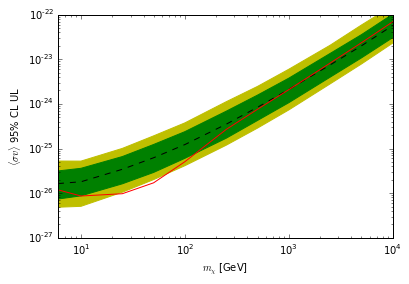

In [72]:
# Ok, let's go ahead and plot the limits against the expectation
f,a = SED.PlotLimits(f_dmlims['bb']['Masses'],f_dmlims['bb']['UL95'],bands['bb']['ulimits'])


#### Question, do these upper limits seem reasonable?

#### Additional questions / excercises

1. How would you calculate upper limits in a Baysian framework?  What potential pit-falls should you be careful of?
1. How do Baysian upper limits compare with what we have done?
1. In a real analysis we would want to incorporate the uncertainty of the J-factor into the upper limits on $\langle \sigma v \rangle$, how could we do that?
1. Several groups have claimed that excess emission near the Galactic center around 3GeV is consistent with a DM signal, e.g. arXiv:1402.6703.   How do the limits we have computed from Draco compare to those claims?


*Thank you for your attention*

** *[Back to the outline](FermiOverview.ipynb#Lecture-outline)* **